In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import datasets, models, transforms
from utils import view_data
from typing import List, Tuple

In [4]:
from easydict import EasyDict as edict
import pickle

In [5]:
args = edict({})
args.image_size = 240
args.batch_size = 25
args.log_interval = 100

In [6]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [7]:
transform_base =  transforms.Compose([
            transforms.Resize((int(args.image_size), int(args.image_size))),
            transforms.ToTensor(),  # Convert the image to pyTorch Tensor data type.
            transforms_norm, ])      
    

In [8]:
#path = '/run/user/1001/gvfs/dav:host=spik.xyz,ssl=true,prefix=%2Fnc%2Fremote.php%2Fdav/files/emmanuel/JNJER_PhD/'
#path = "/envau/work/brainets/dauce.e/data/animal/"
#path = "/media/manu/Seagate Expansion Drive/"
path = "/run/user/1001/gvfs/sftp:host=bag-008-de03/envau/work/brainets/dauce.e/data/ap-10k-test/" #animal/"
path="/home/dauce/tmp/ap-10k-test/"
#path = "../data/animal/"
#image_path = "Data/Imagenet/"
image_path = '' #"Imagenet/"


image_dataset = { 'test' : datasets.ImageFolder(
                            path+image_path+'data',
                            transform=transform_base
                        ),
                }

In [9]:
import json
fname = "imagenet-simple-labels.json"

with open(fname,'r') as f:
    class_labels = json.load(f)
    #labels = f.readlines()
#labels_s = ' '.join(labels)
print(class_labels)
#class_labels = json.loads(labels_s)
#class_labels

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock p

In [10]:
num_workers = 1

dataloader = { 
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [11]:
data, label = next(iter(dataloader['test']))

In [12]:
data.shape

torch.Size([25, 3, 240, 240])

In [13]:
def img_denorm(img, mean, std):
    #for ImageNet the mean and std are:
    #mean = np.asarray([ 0.485, 0.456, 0.406 ])
    #std = np.asarray([ 0.229, 0.224, 0.225 ])

    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))

    res = img.squeeze(0)
    res = denormalize(res)

    #Image needs to be clipped since the denormalize function will map some
    #values below 0 and above 1
    res = torch.clamp(res, 0, 1)
    
    return(res)

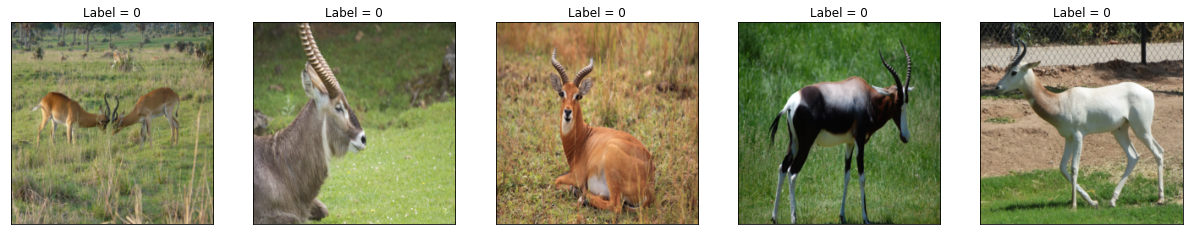

In [14]:
from utils import view_data
for i in range(len(data)):
    data[i] = img_denorm(data[i], v_mean, v_std)
original = view_data(data, label, 5)

In [15]:
len(data)

25

In [16]:
def expand_dim(tensor, dim, desired_dim_len):
    sz = list(tensor.size())
    sz[dim]=desired_dim_len
    return tensor.expand(tuple(sz))

In [17]:
def kl_divergence(model, z):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(z), args.std_sched  * torch.ones_like(z))

    # 2. get the probabilities from the equation
    log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = model.LAMBDA * kl.sum()
    return kl

In [18]:
class Grid_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, do_what=False, LAMBDA=.1, deterministic=False):
        super(Grid_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.do_what = do_what
        self.deterministic = deterministic
        self.LAMBDA = LAMBDA
        
        self.resnet = models.resnet101(pretrained=True) 
        self.resnet_where = models.resnet101(pretrained=True) 
        
        ##  The what pathway
        
        #self.num_features = self.vgg.classifier[-1].in_features
        #features = list(self.vgg.classifier.children())[:-1] # Remove last layer
        #features.extend([nn.Linear(num_features, 500)]) # Add our layer
        #self.vgg.classifier = nn.Sequential(*features) # Replace the model classifier
        
        #self.what_grid = self.logPolarGrid(-1,-6) 
        self.what_grid = self.logPolarGrid(0,-5) 
        
        
        #self.fc_what = nn.Linear(self.num_features, 1000)
        #self.fc_what.weight.data /= torch.sqrt(n_features)
        #self.fc_what.bias.data /= torch.sqrt(n_features)

        ##  The where pathway        
        self.num_features = self.resnet_where.fc.in_features
        n_features = torch.tensor(self.num_features, dtype=torch.float)
        features = list(self.resnet_where.children())[:-1] # Remove last layer
        #features.extend([nn.Linear(num_features, 500)]) # Add our layer
        self.resnet_where = nn.Sequential(*features) # Replace the model classifier
        
        #self.where_grid = self.logPolarGrid(0,-3)
        
        self.mu = nn.Linear(self.num_features, 2) #, bias=False)
        self.logvar = nn.Linear(self.num_features, 2) #, bias=False)
        
        self.mu.weight.data /= torch.sqrt(n_features) 
        self.mu.bias.data /= torch.sqrt(n_features)
        
        self.logvar.weight.data /= torch.sqrt(n_features)
        self.logvar.bias.data /= torch.sqrt(n_features)

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)
        self.dropout = torch.nn.Dropout()
    
    def logPolarGrid(self, a, b, base=2):
        rs = torch.logspace(a, b, args.image_size, base = base)
        ts = torch.linspace(0, torch.pi*2, args.image_size)
        
        grid_xs = torch.outer(rs, torch.cos(ts)) 
        grid_xs = grid_xs.unsqueeze(0).unsqueeze(3)
        grid_xs = Variable(grid_xs, requires_grad=False)

        grid_ys = torch.outer(rs, torch.sin(ts)) 
        grid_ys = grid_ys.unsqueeze(0).unsqueeze(3)
        grid_ys = Variable(grid_ys,  requires_grad=False)
        
        grid = torch.cat((grid_xs, grid_ys), 3)
        grid = expand_dim(grid, 0, args.batch_size)
        
        return grid.to(device)    

    def stn(self: object, x: torch.Tensor) -> Tuple[torch.Tensor]:
    
        logPolx = x #F.grid_sample(x, self.where_grid)
        
        if self.do_stn:
            with torch.no_grad():
                y = self.resnet_where(logPolx).view(-1, self.num_features)
            mu = self.mu(y)
                               
            if self.deterministic:
                sigma = args.radius * torch.ones_like(mu)
                self.q = torch.distributions.Normal(mu, sigma)  
                z = mu
            else:
                logvar = self.logvar(y) + 6
                sigma = torch.exp(-logvar / 2)
                self.q = torch.distributions.Normal(mu, sigma)      
                z = self.q.rsample()
            print(z[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], args.image_size, args.image_size])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            mu = torch.tensor([0, 0],dtype=torch.float)
            mu = mu.unsqueeze(0).repeat(x.size()[0], 1)   
            sigma = torch.tensor([1, 1],dtype=torch.float)
            sigma = sigma.unsqueeze(0).repeat(x.size()[0], 1)    
            
            if self.do_what:
                self.q = torch.distributions.Normal(mu, args.radius * sigma)
                z = self.q.rsample().to(device)
                #z = torch.FloatTensor(z).to(device)
                print(z[0,...])
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
                grid_size = torch.Size([x.size()[0], x.size()[1], args.image_size, args.image_size])
                grid = F.affine_grid(theta, grid_size)
                x = F.grid_sample(x, grid)
            else:
                z = torch.tensor([0, 0],dtype=torch.float)
                z = z.unsqueeze(0).repeat(x.size()[0], 1)

                theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                    dtype=torch.float),
                                        requires_grad=False)
                theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            
           
        return x, theta, z

    def forward(self, x):
        # transform the input
        x, theta, z = self.stn(x)
        
        logPolx = F.grid_sample(x, self.what_grid)
        if True: #with torch.no_grad():
            y = self.resnet(logPolx)  
        #y = self.fc_what(y)
       
        return y, theta, z


In [19]:
lr = 1e-4
LAMBDA = 1e-6
do_stn=True
deterministic=True
radius = 0.5

In [20]:
args.radius = radius

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Grid_AttentionTransNet(do_stn=do_stn, deterministic=deterministic).to(device)

In [22]:
path = 'out/'
save_path = "out/"
f_load_init = f"resnet_polar_1000"
f_load = f""



In [23]:
saved_params_init = torch.load(save_path+f_load_init+'.pt', map_location=device)
#saved_params = torch.load(save_path+f_load+'.pt', map_location=device)
model.resnet.load_state_dict(saved_params_init, strict=False)    
#model.load_state_dict(saved_params, strict=False)    
model.LAMBDA = LAMBDA

In [62]:
saved_params_init = torch.load(save_path+f_load_init+'.pt', map_location=device)
model_resnet = models.resnet101(pretrained=True)
model_resnet.load_state_dict(saved_params_init, strict=False)  


<All keys matched successfully>

In [62]:
saved_params_init = torch.load(save_path+f_load_init+'.pt', map_location=device)
class A:
    pass
test_model = A()
test_model.resnet = models.resnet101(pretrained=True)
test_model.resnet.load_state_dict(saved_params_init, strict=False)  


<All keys matched successfully>

In [63]:
test_model.resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [58]:
#model_resnet = model.resnet

In [49]:
model.do_stn = False
model.do_what = False

In [64]:
data, data_aff, target, cat, theta, z = [[]]*10, [[]]*10, [[]]*10, [[]]*10, [[]]*10, [[]]*10
center = args.image_size / 2 - 0.5 #np.array([a, args.image_size/2-0.5])
h_width = args.image_size / 2
n_samples = 1

for i in range(n_samples):
    data[i], target[i] = next(iter(dataloader['test']))
    with torch.no_grad():
        #c, theta[i], z[i] = model(data[i].to(device))
        logPolx = F.grid_sample(data[i].to(device), model.what_grid)
        c = test_model.resnet(logPolx) #model_resnet(logPolx) #
    #cat[i] = torch.argmax(F.softmax(c),1)
    cat[i] = torch.argmax(c,1)
    data_aff[i] = [[]] * args.batch_size
    for j in range(len(data[i])):
        data_aff[i][j] = img_denorm(data[i][j], v_mean, v_std)

In [65]:

'''for i in range(n_samples):

    for num in range(args.batch_size):
        plt.figure(figsize=(5,10))
        plt.subplot(1,2,1)
        img = data_aff[i][num].unsqueeze(0)
        th = theta[i][num:num+1,...]
        #theta[0,:,2] = torch.FloatTensor((0,.5))
        #print(th)
        grid_size = torch.Size([1, 3, 240, 240])
        grid = F.affine_grid(th, grid_size)
        img_grid = F.grid_sample(img, grid)
        plt.imshow(data_aff[i][num].permute(1,2,0).detach().numpy())
        plt.title(str(num)+', '+str(target[i][num]))
        plt.subplot(1,2,2)
        plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
        plt.plot(center, center,'w+')
        plt.title(cat[i][num])'''

"for i in range(n_samples):\n\n    for num in range(args.batch_size):\n        plt.figure(figsize=(5,10))\n        plt.subplot(1,2,1)\n        img = data_aff[i][num].unsqueeze(0)\n        th = theta[i][num:num+1,...]\n        #theta[0,:,2] = torch.FloatTensor((0,.5))\n        #print(th)\n        grid_size = torch.Size([1, 3, 240, 240])\n        grid = F.affine_grid(th, grid_size)\n        img_grid = F.grid_sample(img, grid)\n        plt.imshow(data_aff[i][num].permute(1,2,0).detach().numpy())\n        plt.title(str(num)+', '+str(target[i][num]))\n        plt.subplot(1,2,2)\n        plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())\n        plt.plot(center, center,'w+')\n        plt.title(cat[i][num])"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


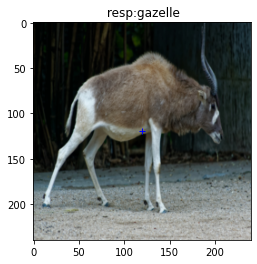

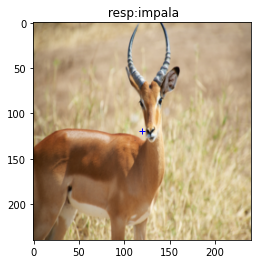

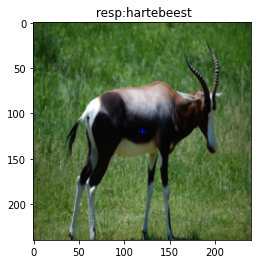

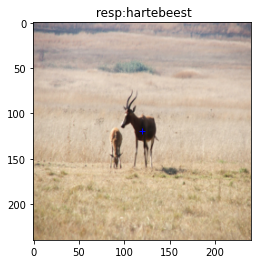

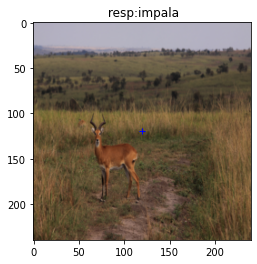

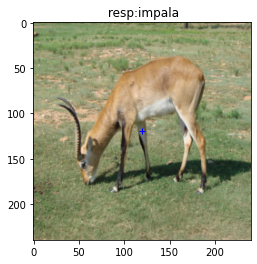

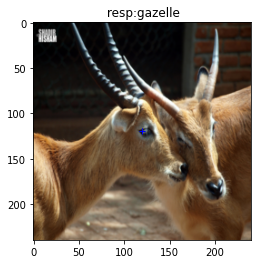

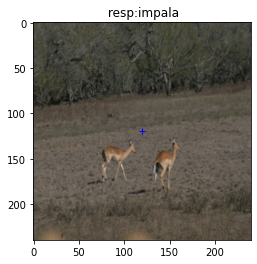

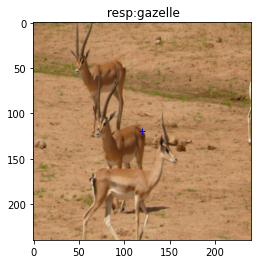

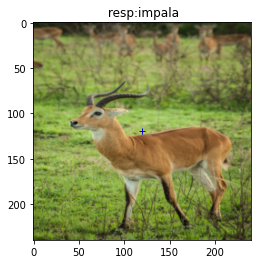

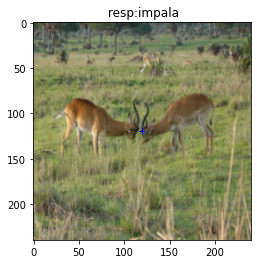

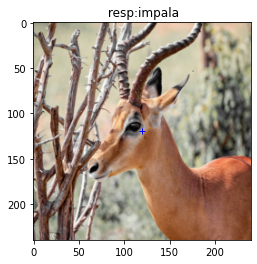

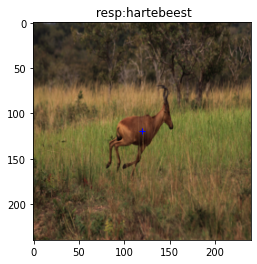

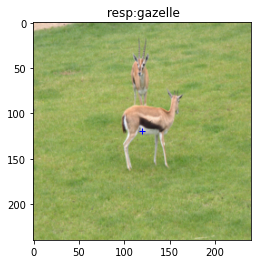

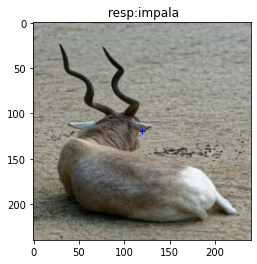

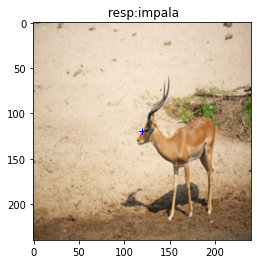

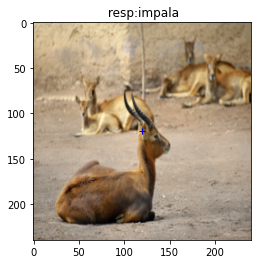

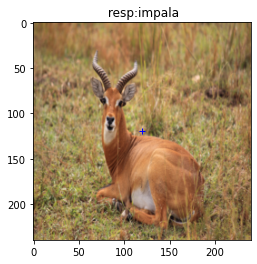

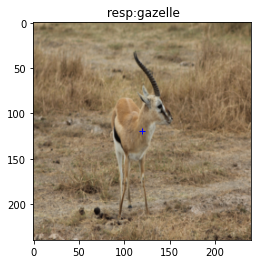

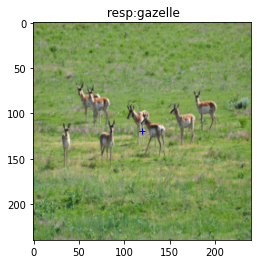

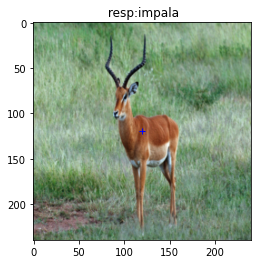

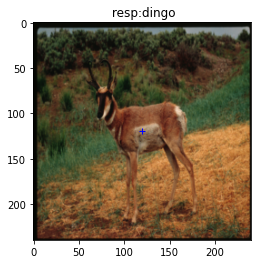

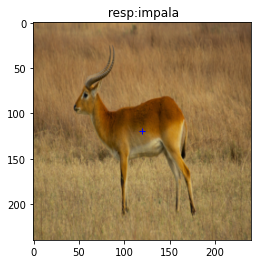

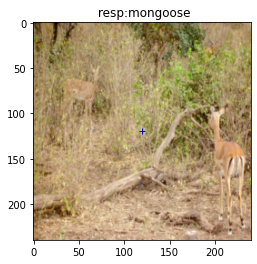

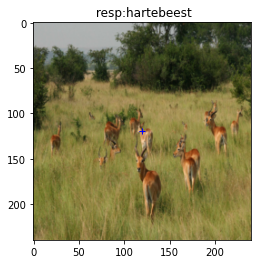

In [66]:
for i in range(n_samples):
    for num in range(args.batch_size):
        plt.figure()
        plt.imshow((data_aff[i][num].permute(1,2,0).detach().numpy()))
        plt.plot(center,center,'b+')
        #plt.title('true:'+str(target[i][num])+' resp:'+str(cat[i][num]))
        plt.title(' resp:'+class_labels[cat[i][num]])
        #plt.plot(center + z[i][num][0]*h_width, center + z[i][num][1]*h_width,'r+')
        #plt.plot([center, center + z[i][num][0]*h_width], [center, center +z[i][num][1]*h_width],'r--')
       

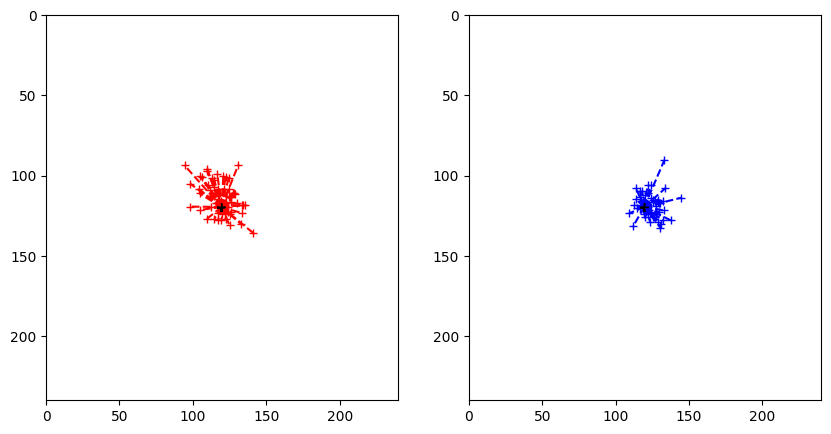

In [32]:
#data, target, cat, theta, z = [[]]*10, [[]]*10, [[]]*10, [[]]*10, [[]]*10
center = args.image_size / 2 - 0.5 #np.array([a, args.image_size/2-0.5])
#h_width = args.image_size / 2
plt.figure(figsize=(10,5))
for i in range(n_samples):
    for num in range(args.batch_size):
        if cat[i][num] < 500:
            ax = plt.subplot(1,2,1)
            ax.plot(center + z[i][num][0]*h_width, center + z[i][num][1]*h_width,'r+')
            ax.plot([center, center + z[i][num][0]*h_width], [center, center +z[i][num][1]*h_width],'r--')
        else:
            ax = plt.subplot(1,2,2)
            ax.plot(center + z[i][num][0]*h_width, center + z[i][num][1]*h_width,'b+')
            ax.plot([center, center + z[i][num][0]*h_width], [center, center +z[i][num][1]*h_width],'b--')        
        plt.plot(center, center,'k+')
        ax.set_xlim(0,args.image_size)
        ax.set_ylim(0,args.image_size)
for ax in (plt.subplot(1,2,1), plt.subplot(1,2,2)):
    ax.invert_yaxis()


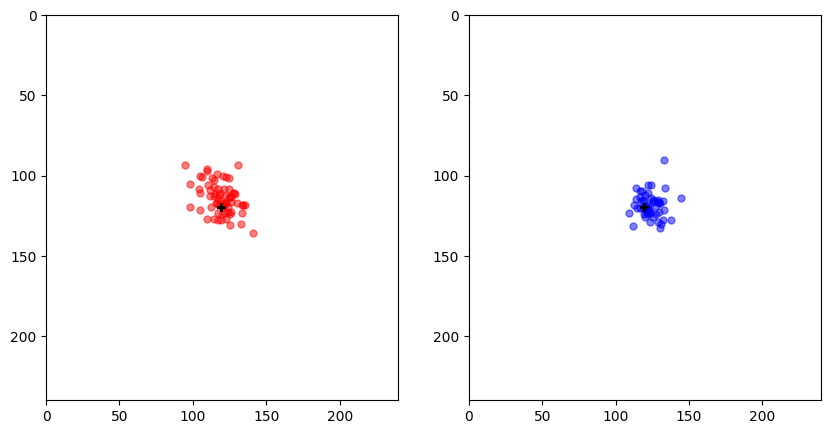

In [33]:
#data, target, cat, theta, z = [[]]*10, [[]]*10, [[]]*10, [[]]*10, [[]]*10
center = args.image_size / 2 - 0.5 #np.array([a, args.image_size/2-0.5])
#h_width = args.image_size / 2
plt.figure(figsize=(10,5))
for i in range(n_samples):
    for num in range(args.batch_size):
        if cat[i][num] < 500:
            ax = plt.subplot(1,2,1)
            ax.plot(center + z[i][num][0].item()*h_width, center + z[i][num][1].item()*h_width,'.r', markersize=10, alpha=.5)
            #ax.plot([center, center + z[i][num][0]*h_width], [center, center +z[i][num][1]*h_width],'r--')
        else:
            ax = plt.subplot(1,2,2)
            ax.plot(center + z[i][num][0].item()*h_width, center + z[i][num][1].item()*h_width,'.b', markersize=10, alpha=.5)
            #ax.plot([center, center + z[i][num][0]*h_width], [center, center +z[i][num][1]*h_width],'b--')        
        plt.plot(center, center,'k+')
        ax.set_xlim(0,args.image_size)
        ax.set_ylim(0,args.image_size)
for ax in (plt.subplot(1,2,1), plt.subplot(1,2,2)):
    ax.invert_yaxis()


In [34]:
center + z[i][num][0]*h_width, center + z[i][num][1]*h_width

(tensor(122.7121), tensor(121.4909))

In [35]:
mem_z  = {}
mem_cat  = {}

In [29]:
7*7*512

25088